# Language Technology - 6th Tutorial on CNNs for Text Classification with Keras


----
## Important Resources

Language Technology Resources: https://eclass.aueb.gr/modules/document/index.php?course=INF210

Python Official Documentation: https://docs.python.org/3.5/

Keras: https://keras.io/

Keras examples: https://github.com/fchollet/keras/tree/master/examples

----

## Tutorial 6 Schedule

**In order to familiarize ourselves with Neural Networks, we have the following sections:**

* **Text Classification based on CNNs**

Again we will use the IMDB binary sentiment analysis datasets.

**Python Example Code**

In [43]:
from keras.datasets import imdb

# Load IMDB Dataset
vocab_size = 100000
maxlen = 100

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# Load IMDB vocabulary
imdb_index = {index: word for word, index in imdb.get_word_index().items()}
print(len(imdb_index), 'tokens in vocabulary')

# Load 200-dimensional GloVe embeddings index
import pickle

with open('/Users/kiddo/Documents/TUTORIALS/glove.6B.200d.index', 'rb') as file:
    glove_index = pickle.load(file)


# Build datasets with GloVe word indices

import numpy as np

x_train_v2 = np.zeros((len(x_train), maxlen,), dtype=np.int32)
for i, sample in enumerate(x_train):
    for j, token_index in enumerate(sample[:maxlen]):
        # If word in vocabylary
        if token_index - 3 in imdb_index and imdb_index[token_index - 3] in glove_index:
            x_train_v2[i][j] = glove_index[imdb_index[token_index - 3]]
            
x_test_v2 = np.zeros((len(x_test), maxlen,), dtype=np.int32)
for i, sample in enumerate(x_test):
    for j, token_index in enumerate(sample[:maxlen]):
        # If word in vocabylary
        if token_index - 3 in imdb_index and imdb_index[token_index - 3] in glove_index:
            x_test_v2[i][j] = glove_index[imdb_index[token_index - 3]]

print('x_train shape:', x_train_v2.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test_v2.shape)
print('y_test shape:', y_test.shape)


Loading data...
25000 train sequences
25000 test sequences
88584 tokens in vocabulary
x_train shape: (25000, 100)
y_train shape: (25000,)
x_test shape: (25000, 100)
y_test shape: (25000,)


## Text Classification Architectures based on CNNs

CNNs are employed over word sequences in three modes:

* Valid (No padding): a representation per n-gram.
* Same (Padding): a representation per token (timestep).
* Causal (Padding-Dilation): a representation per token appliyng dilated CNNs.

CNNs like RNNs are usually followed by a pooling mechanism in order to produce a fixed-size sequence representation:

* Use a pooling mechanism over time (e.g., MaxPooling, MeanPooling)
* Use self-attention mechanisms.


---

### Stacked CNNs followed by Max-Pooling

**Python Example Code**

In [19]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

inputs =  Input(shape=(100, ), dtype='int32')
# Embeddings
embeddings = Embedding(20000, 50, input_length=100)(inputs)
# Dropout over Embeddings
dropped_embeddings = Dropout(rate=0.2)(embeddings)
# Stack of Convolutions for tri-grams without padding
convs = Conv1D(filters=100, kernel_size=3, strides=1, padding='valid', activation='relu')(dropped_embeddings)
convs = Conv1D(filters=200, kernel_size=3, strides=1, padding='valid', activation='relu')(convs)
convs = Conv1D(filters=50, kernel_size=3, strides=1, padding='valid', activation='relu')(convs)
# Max-Pooling over time
pooled_convs =  GlobalMaxPooling1D()(convs)
outputs = Dense(2, activation='softmax')(pooled_convs)
# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_14 (InputLayer)                            (None, 100)                                 0                
______________________________________________________________________________________________________________
embedding_14 (Embedding)                         (None, 100, 50)                             1000000          
______________________________________________________________________________________________________________
dropout_15 (Dropout)                             (None, 100, 50)                             0                
______________________________________________________________________________________________________________
conv1d_15 (Conv1D)                               (None, 98, 100)                             15100            
_

### Multi-filter CNNs (Kim, 2014)

<img src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png"/>

**Python Example Code**

In [20]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, concatenate

inputs =  Input(shape=(100, ), dtype='int32')
# Embeddings
embeddings = Embedding(20000, 50, input_length=100)(inputs)
# Dropout over Embeddings
dropped_embeddings = Dropout(rate=0.5)(embeddings)
# Multi-filter CNNs
pooled_convs = []
for n_gram in range(3,6):
    # n-gram Convolutions with padding
    convs = Conv1D(filters=100, kernel_size=n_gram, strides=1, 
                    padding='same', activation='relu', 
                    name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)
    # Max-Pooling over time
    pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))
# Concatenation of filters form all window sizes
concat =  concatenate(pooled_convs)
concat = Dropout(rate=0.5)(concat)
outputs = Dense(2, activation='softmax')(concat)
# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_15 (InputLayer)               (None, 100)             0                                                 
______________________________________________________________________________________________________________
embedding_15 (Embedding)            (None, 100, 50)         1000000      input_15[0][0]                       
______________________________________________________________________________________________________________
dropout_16 (Dropout)                (None, 100, 50)         0            embedding_15[0][0]                   
______________________________________________________________________________________________________________
3-gram_Convolutions (Conv1D)        (None, 100, 100)        15100        dropout_16[0][0]                     
_

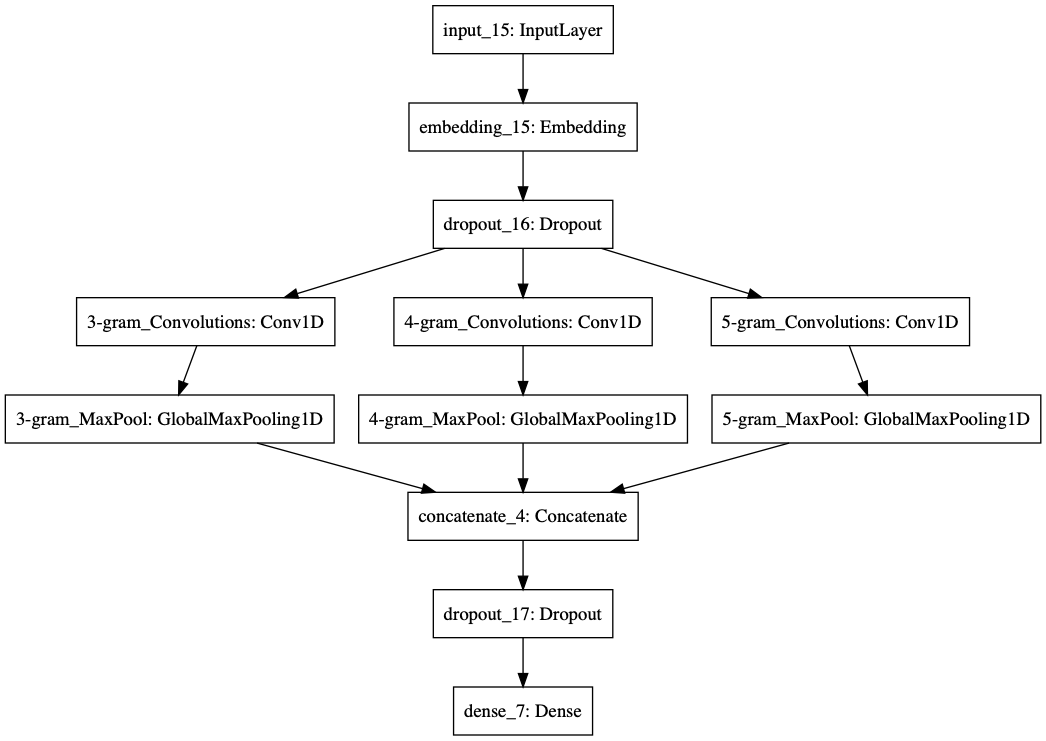

In [21]:
%matplotlib notebook

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image 
Image('model.png')

### ByteNet encoder (Kalchbrenner et al., 2016)

<img src="https://cdn-images-1.medium.com/max/1600/1*iBnuidVcY5gPbWCKgmquzA.png" />

---

### Pre-trained Embeddings

**Python Example Code**

In [39]:
from gensim.models import KeyedVectors
import numpy as np

def PretrainedEmbedding(word_embeddings_path=None):
    embeddings = KeyedVectors.load_word2vec_format(word_embeddings_path, binary=True)
    word_encodings_weights = np.concatenate((np.zeros((1, embeddings.vectors.shape[-1]), dtype=np.float32), 
                                             embeddings.vectors), axis=0)
    embedding_layer = Embedding(len(word_encodings_weights), word_encodings_weights.shape[-1],
                                weights=[word_encodings_weights], trainable=False, name='pretrained_embeddings')

    return embedding_layer

### Layer Normalization

**Python Example Code**

In [24]:
from keras import backend as K
from keras.layers.core import Layer
from keras.initializers import Ones, Zeros


class LayerNormalization(Layer):
    def __init__(self, eps: float = 1e-5, **kwargs) -> None:
        self.eps = eps
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:], initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:], initializer=Zeros(), trainable=True)
        super().build(input_shape)

    def call(self, x, **kwargs):
        u = K.mean(x, axis=-1, keepdims=True)
        s = K.mean(K.square(x - u), axis=-1, keepdims=True)
        z = (x - u) / K.sqrt(s + self.eps)
        return self.gamma * z + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'eps': self.eps,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [52]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D, Dense, add


GLOVE_PATH = '/Users/kiddo/Documents/TUTORIALS/glove.6B.200d.bin'
n_hidden_blocks = 6

inputs =  Input(shape=(100, ), dtype='int32', name='word_ids')
# Embeddings
embeddings = PretrainedEmbedding(GLOVE_PATH)(inputs)
# Dropout over Embeddings
encodings = Dropout(rate=0.2)(embeddings)
# Consecutive Dilated Convolution blocks with residual connections
for i in range(n_hidden_blocks):
    # LayerNorm
    block_encodings = LayerNormalization(name ='LayerNorm_{}'.format(i+1))(encodings)
    # Dilation i - Receptive field 2^n
    block_encodings = Activation("relu", name ='ReLU_IN_{}'.format(i+1))(block_encodings)
    block_encodings = Conv1D(filters=100, kernel_size=1, strides=1, padding="same",
                             name ='Conv_IN_{}'.format(i+1,r))(block_encodings)
    block_encodings = Activation("relu", name ='ReLU_DIL_{}'.format(i+1))(block_encodings)
    block_encodings = Conv1D(filters=100, kernel_size=3, strides=1, padding="same", 
                             dilation_rate=2 ** i,
                             name ='Conv_DIL_{}'.format(i+1))(block_encodings)
    block_encodings = Activation("relu", name ='ReLU_OUT_{}'.format(i+1))(block_encodings)
    block_encodings = Conv1D(filters=200, kernel_size=1, strides=1, padding="same",
                             name ='Conv_OUT_{}'.format(i+1))(block_encodings)
    # Merge CNNs feature vectors with the previous ones
    encodings = add([block_encodings, encodings], name='Residual_{}'.format(i+1))
    encodings = Dropout(rate=0.2)(encodings)

# Max-Pooling over time
pooled_convs =  GlobalMaxPooling1D()(encodings)

pooled_convs = Dropout(rate=0.2)(pooled_convs)
outputs = Dense(1, activation='sigmoid')(pooled_convs)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)

# Print topology
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
word_ids (InputLayer)               (None, 100)             0                                                 
______________________________________________________________________________________________________________
pretrained_embeddings (Embedding)   (None, 100, 200)        80000600     word_ids[0][0]                       
______________________________________________________________________________________________________________
dropout_61 (Dropout)                (None, 100, 200)        0            pretrained_embeddings[0][0]          
______________________________________________________________________________________________________________
LayerNorm_1 (LayerNormalization)    (None, 100, 200)        400          dropout_61[0][0]                     
_

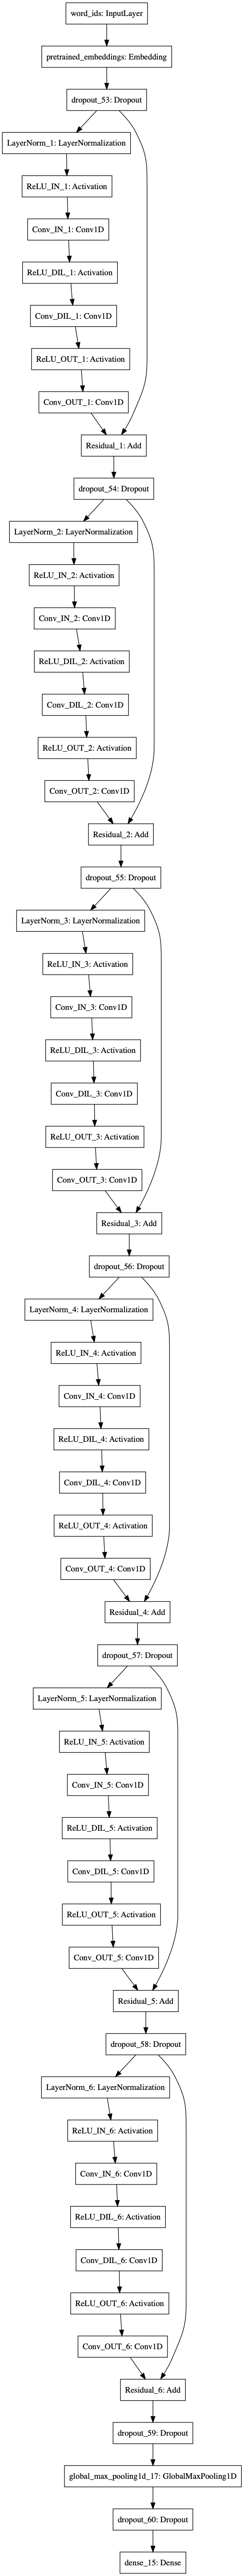

In [50]:
%matplotlib notebook

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image 
Image('model.png')

### Train ByteNet model from scratch

In [53]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile model
model.compile(optimizer=Adam(lr=0.001, clipvalue=2.0), loss='binary_crossentropy', metrics=['accuracy'])

# Initialize callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='CHECKPOINT_1.hdf5', monitor='val_loss', mode='auto',
                                   verbose=1, save_best_only=True, save_weights_only=True)

# Train model with callbacks
print('Train...')
history = model.fit(x_train_v2, y_train,
                    batch_size=16,
                    epochs=15,
                    validation_data=(x_test_v2, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 234s 9ms/step - loss: 0.7039 - acc: 0.6295 - val_loss: 0.8538 - val_acc: 0.5241

Epoch 00001: val_loss improved from inf to 0.85379, saving model to CHECKPOINT_1.hdf5
Epoch 2/15
25000/25000 [==============================] - 216s 9ms/step - loss: 0.5060 - acc: 0.7514 - val_loss: 0.7647 - val_acc: 0.5850

Epoch 00002: val_loss improved from 0.85379 to 0.76466, saving model to CHECKPOINT_1.hdf5
Epoch 3/15
25000/25000 [==============================] - 221s 9ms/step - loss: 0.4712 - acc: 0.7719 - val_loss: 0.8074 - val_acc: 0.5884

Epoch 00003: val_loss did not improve from 0.76466
Epoch 4/15
25000/25000 [==============================] - 230s 9ms/step - loss: 0.4491 - acc: 0.7848 - val_loss: 0.6594 - val_acc: 0.6526

Epoch 00004: val_loss improved from 0.76466 to 0.65941, saving model to CHECKPOINT_1.hdf5
Epoch 5/15
25000/25000 [==============================] - 228s 9ms/s

<IPython.core.display.Javascript object>


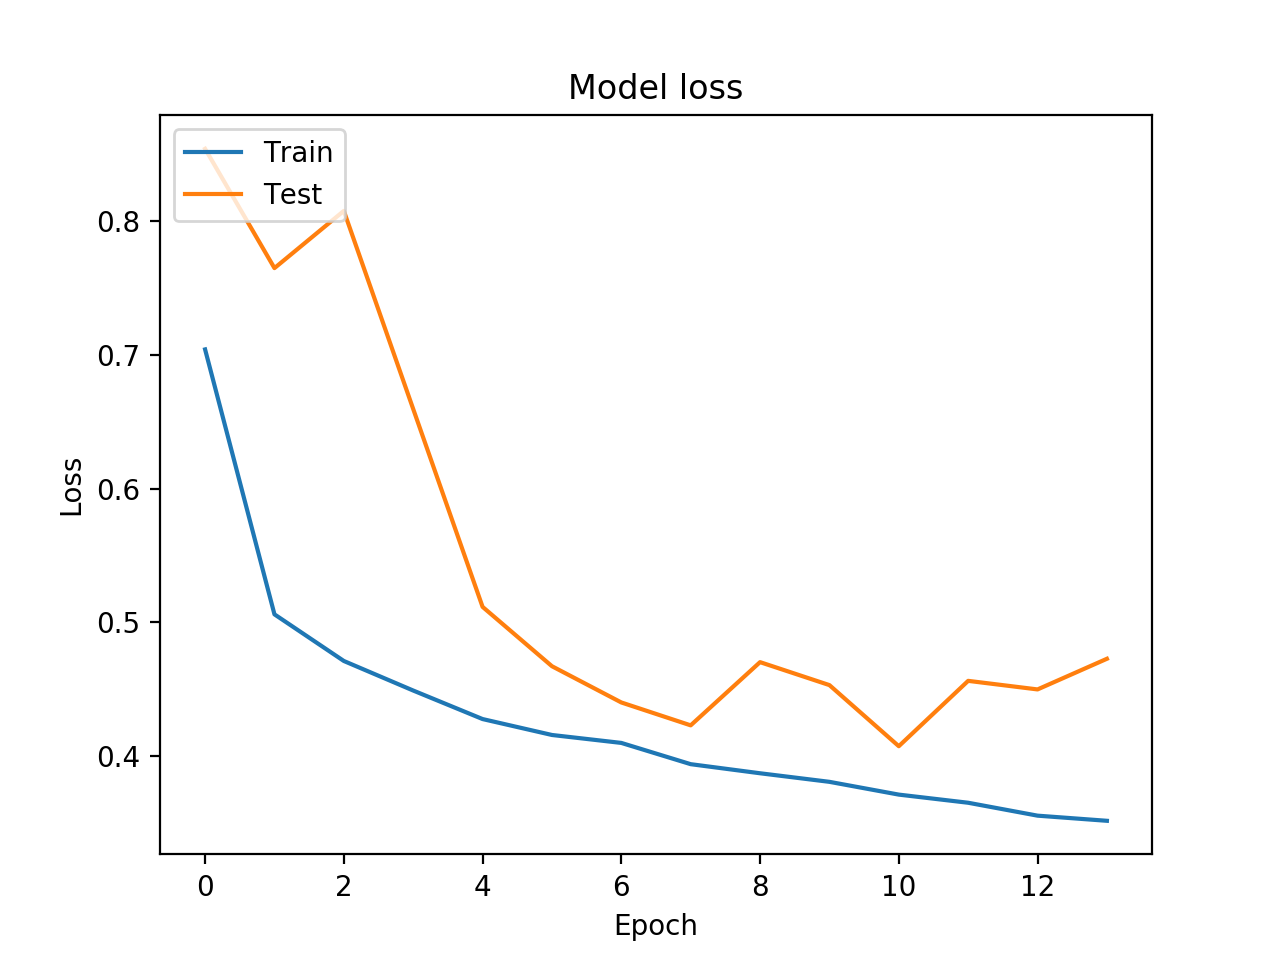

In [54]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
from sklearn import metrics

# Evaluate
y_prob = model.predict(x_test_v2, batch_size=1, verbose=0)
print(metrics.classification_report(y_test, (y_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     12500
           1       0.79      0.87      0.83     12500

   micro avg       0.82      0.82      0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

